# Exploratory Data Analysis

Spencer Brothers

IS 6812 Spring 2025

## Table of Contents

1. Introduction

2. Exploring the target variable

3. Missing data in application_{train|test}.csv

4. Exploring relationships Between Target and Predictors

5. Investigating Problems in the Data

6. Transforming Input Data

7. Exploring Joined Data

8. Results

## Introduction

### Business Problem

Most lending services are based on credit, which excludes a large demographic of people (those with no credit history) from buying a home. Taking an uninformed lending approach is an unsustainable business practice that may leave underserved populations worse off, so using smart lending practices is essential to both Home Credit’s longevity and financial equity for unbanked populations.

### Benefit of a Solution

By better understanding clients’ behaviors, Home Credit can successfully predict clients’ repayment abilities. This supports Home Credit’s goals in two key areas:

1.	Home Credit will decrease costs of clients defaulting on loans, supporting Home Credit’s sustainability in an ever-changing economic and political ecosystem.

2.	Clients capable of repayment will receive necessary resources that empower their financial success when other financial institutions fail to lend. Loans will be given with principal, maturity, and a repayment schedule that optimizes clients’ lending experience

### Exploratory Data Analysis

The purposes of this exploratory data analysis is to become more familiarized with the data, explore potential issues with the data, and investigate factors that may help us build a better model in predicting whether or not individuals will have a good experience. 

The Target of our model is the `TARGET` column in `application_{train|test}.csv`. If applicants had late payments during their lending experience, the value of `TARGET` will be `1` and if not, `0`. It essentially states whether clients have had a good lending experience. By better predicting `TARGET`, Home Credit can both reduce costs of default and late payments and better service populations that need it.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

## Exploring the Target Variable

Because application_test.csv is the same schema as the train file (without the target), we'll look at the train file only.

*See README if pulling project from GitHub Repository*

In [4]:
# read the main file with the target into a pandas dataframe
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
# get info on the table
app_train.info()
app_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


There are 122 columns and 307,511 rows in the training set. There are 121 columns and 48,744 rows in the testing set. Many columns are just checking if applicants submitted certain documents (according to kaggle). The "object" dtype columns are really strings. Let's take a closer look at the target. 

In [6]:
# find what columns are present in the train set that aren't present in the testing set and vice-versa
print(app_train.columns[~app_train.columns.isin(app_test.columns)].values)
print(app_test.columns[~app_test.columns.isin(app_train.columns)].values)

['TARGET']
[]


The only difference between the two schemas is that the training set contains the target, while the testing set does not.

   counts  proportions
0  282686     0.919271
1   24825     0.080729


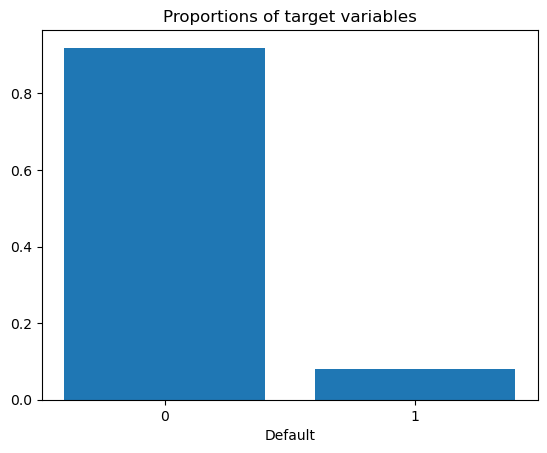

In [8]:
# Find the distribution of the target variable
target_dist = app_train.value_counts('TARGET')
target_props = pd.DataFrame({
    'counts': target_dist.values,
    'proportions': target_dist.values/len(app_train)})
print(target_props)
# plot the proportions
plt.bar(target_props.index.astype(str),target_props['proportions'])
plt.title('Proportions of target variables')
plt.xlabel('Default')
plt.show()

There's a very large imbalance in the target classes, with only about 8.1% of applicants defaulting. A simple majority class classifier would classify all applicants as not defaulting (with an accuracy of about 91.9%), which would be detrimental to the applicants who would default as well as Home Credit. 

## Missing data in application_{train|test}.csv

- TODO: Explore the scope of missing data in application_{train|test}.csv and come up with possible solutions. Remove rows?  Remove columns?  Impute?

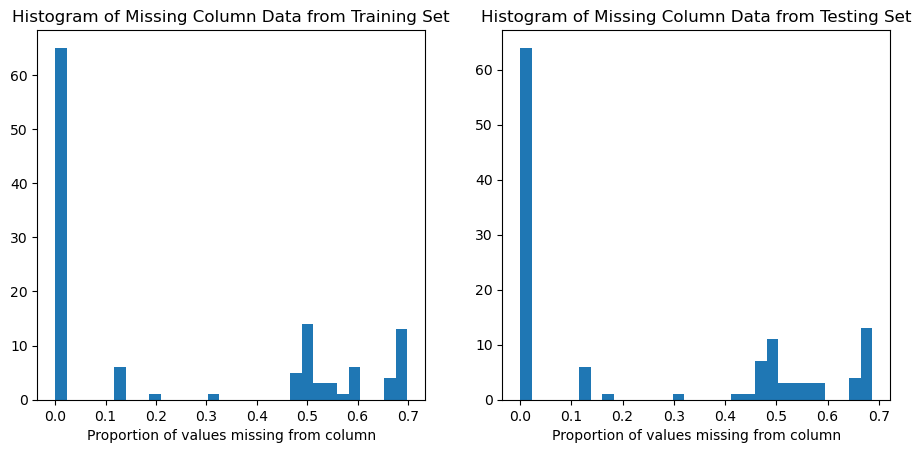


67 columns contain missing values from test set. 



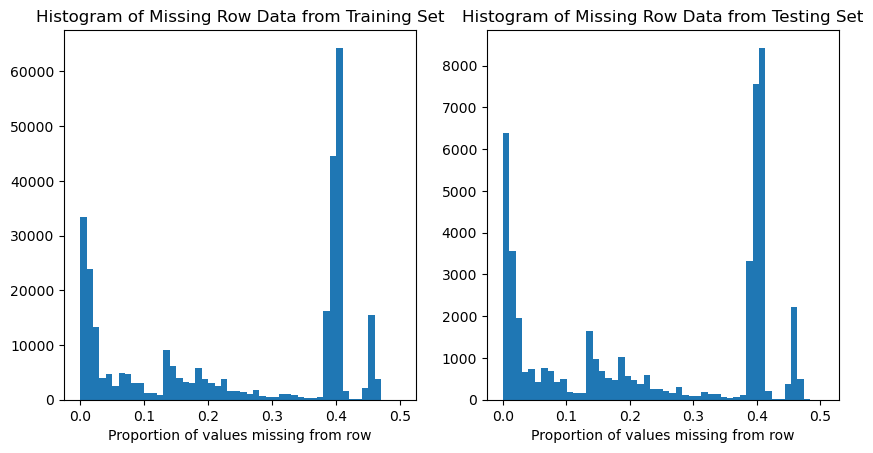

In [11]:
# Plot a histogram showing the distribution of missing data among the 122 columns
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(11)
axs[0].hist(app_train.isna().sum()/len(app_train), bins=30)
axs[1].hist(app_test.isna().sum()/len(app_test), bins=30)
axs[0].set_title('Histogram of Missing Column Data from Training Set')
axs[1].set_title('Histogram of Missing Column Data from Testing Set')
axs[0].set_xlabel('Proportion of values missing from column')
axs[1].set_xlabel('Proportion of values missing from column')
plt.show()

# get info on columns missing values
print(f'\n{app_train.isna().any().sum()} columns contain missing values from test set. \n')
# print(f'These rows are:\n {app_train.columns[app_train.isna().any()].values}')

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)

axs[0].hist(app_train.isna().mean(axis=1), bins=50)
axs[1].hist(app_test.isna().mean(axis=1), bins=50)
axs[0].set_title('Histogram of Missing Row Data from Training Set')
axs[1].set_title('Histogram of Missing Row Data from Testing Set')
axs[0].set_xlabel('Proportion of values missing from row')
axs[1].set_xlabel('Proportion of values missing from row')

plt.show()

The distributions of missing columnwise data are very similar, and likewise for the distributions of missing row data. Let's analyze which columsn in particular are missing from each dataset.

In [13]:
# find columns that are missing more than 50% of data from training set
num_cols_train = app_train.shape[1]
large_missing_train = app_train.columns[app_train.isna().sum()/num_cols_train > 0.5].values
print(large_missing_train)
print(f'\n{len(large_missing_train)} columns missing more than 50% of data from the Training set')

['AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'OWN_CAR_AGE' 'OCCUPATION_TYPE'
 'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG'
 'BASEMENTAREA_AVG' 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG'
 'COMMONAREA_AVG' 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOORSMAX_AVG'
 'FLOORSMIN_AVG' 'LANDAREA_AVG' 'LIVINGAPARTMENTS_AVG' 'LIVINGAREA_AVG'
 'NONLIVINGAPARTMENTS_AVG' 'NONLIVINGAREA_AVG' 'APARTMENTS_MODE'
 'BASEMENTAREA_MODE' 'YEARS_BEGINEXPLUATATION_MODE' 'YEARS_BUILD_MODE'
 'COMMONAREA_MODE' 'ELEVATORS_MODE' 'ENTRANCES_MODE' 'FLOORSMAX_MODE'
 'FLOORSMIN_MODE' 'LANDAREA_MODE' 'LIVINGAPARTMENTS_MODE'
 'LIVINGAREA_MODE' 'NONLIVINGAPARTMENTS_MODE' 'NONLIVINGAREA_MODE'
 'APARTMENTS_MEDI' 'BASEMENTAREA_MEDI' 'YEARS_BEGINEXPLUATATION_MEDI'
 'YEARS_BUILD_MEDI' 'COMMONAREA_MEDI' 'ELEVATORS_MEDI' 'ENTRANCES_MEDI'
 'FLOORSMAX_MEDI' 'FLOORSMIN_MEDI' 'LANDAREA_MEDI' 'LIVINGAPARTMENTS_MEDI'
 'LIVINGAREA_MEDI' 'NONLIVINGAPARTMENTS_MEDI' 'NONLIVINGAREA_MEDI'
 'FONDKAPREMONT_MODE' 'HOUSETYPE_MODE' 'TOTALAR

### Let's explore some of the missing columns

'AMT_GOODS_PRICE'
- For consumer loans, it is the price of the goods for which the loan is given.
- This seems important, so let's not remove it.

'OWN_CAR_AGE"
- Age of clients car.
- many clients dont own cars, as seen in 'FLAG_OWN_CAR'. This missing data is structural

'OCCUPATION_TYPE'
- What kind of occupation does client have?
- Structural missingness, related to 'DAYS_EMPLOYED'

'EXT_SOURCE_*'
- Highly predictive scores from external credit bureaus.
- Binning would be a great strategy for these columns

In [15]:
# how does this differ from the training set?
num_cols_test = app_test.shape[1]
large_missing_test = app_test.columns[app_test.isna().sum() / num_cols_test > 0.5].values

print(list(filter(lambda x: x not in large_missing_train, large_missing_test)))
print(list(filter(lambda x: x not in large_missing_test, large_missing_train)))


#The training set has a few more columns with more than 50% missing values than the test set, which is tricky for building a model. 

[]
['AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']


Let's handle those missing columns. First we'll convert the categorical columns (from the data dictionary) into string values.

In [17]:
# Manually selected categorical columns based on data dictionary
categorical_columns = [ 
    'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
    'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'OWN_CAR_AGE', 
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG','YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG',
    'ENTRANCES_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
    'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI',  'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FLAG_DOCUMENT_2', 
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 
    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'REG_REGION_NOT_LIVE_REGION',
    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY'
]

# Convert categorical columns to strings
app_train[categorical_columns] = app_train[categorical_columns].astype(str)


Now, let's handle missing values by imputing columns with little missing values and binning colums with many missing values

In [19]:
# Identify numerical columns with significant missing values
missing_threshold = 0.5
num_cols = app_train.select_dtypes(include=['number']).columns
missing_num_cols = [col for col in num_cols if app_train[col].isnull().mean() > missing_threshold]

# Bin numerical columns with many missing values using quantiles and add "NO DATA" category
for col in missing_num_cols:
    app_train[col] = pd.qcut(app_train[col].rank(method='first'), q=5, duplicates='drop',
                             labels=["Very Low", "Low", "Medium", "High", "Very High"])
    app_train[col] = app_train[col].astype(str)
    app_train.loc[app_train[col].isnull(), col] = "NO DATA"

# Impute remaining missing numerical values with median
imputer_numeric = SimpleImputer(strategy='median')
app_train[num_cols] = imputer_numeric.fit_transform(app_train[num_cols])

# Verify missing values are handled
print(app_train.isnull().sum().sum())  # Should print 0

0


## Exploring Relationships Between Target and Predictors

We will use a simple decision tree to determine feature importance in our model.


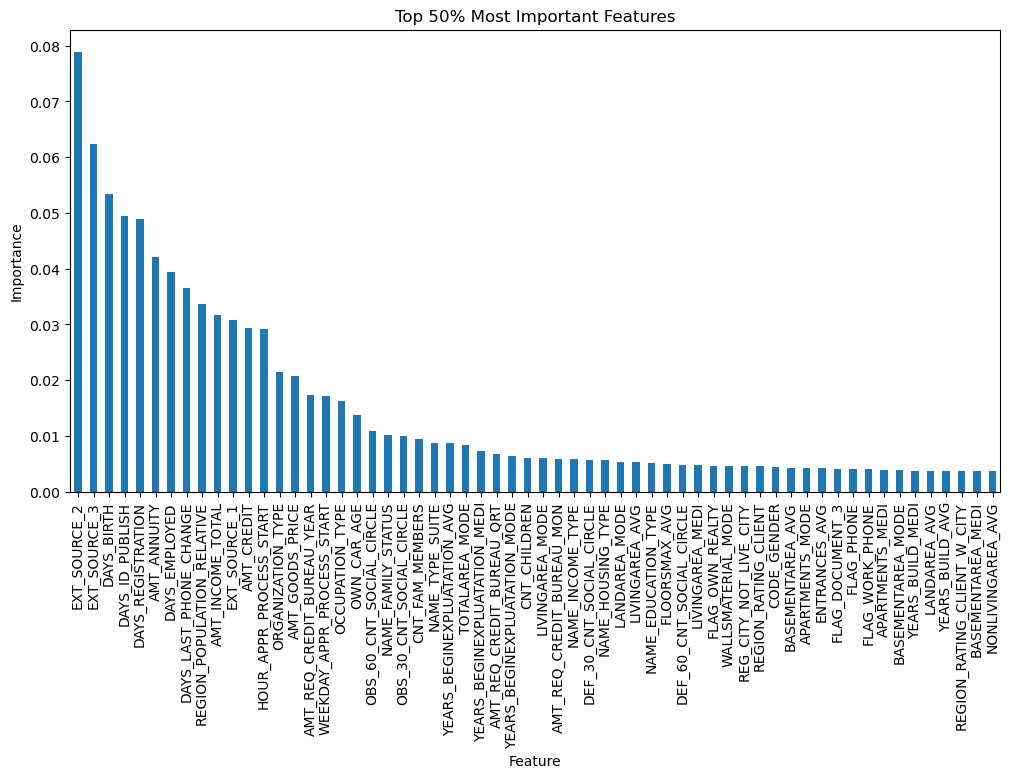

Training Accuracy: 1.0000
Test Accuracy: 0.8512


In [21]:
# Identify categorical columns
categorical_columns = app_train.select_dtypes(include=['object']).columns

# Store label encoders for decoding later
label_encoders = {}

# Apply Label Encoding to categorical columns
for col in categorical_columns:
    le = LabelEncoder()
    app_train[col] = le.fit_transform(app_train[col].astype(str))
    label_encoders[col] = le  # Store encoder

# Split dataset into features and target
X = app_train.drop(columns=['TARGET', 'SK_ID_CURR'])  # Replace 'TARGET' with actual target column name
y = app_train['TARGET']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Feature importance
feature_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Select the top 50% most important features
top_n = int(len(feature_importances) * 0.5)
top_features = feature_importances[:top_n]

# Plot
plt.figure(figsize=(12, 6))
top_features.plot(kind='bar', title='Top 50% Most Important Features')
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

# Model performance
train_score = dt_model.score(X_train, y_train)
test_score = dt_model.score(X_test, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

# Decode categorical variables back to original labels
for col, le in label_encoders.items():
    app_train[col] = le.inverse_transform(app_train[col])

here, the feature importance is the normalized information gain from splits on each variable. It's worth noting that the accuracy of this model is lower than a simple majority classifier. Whats worse is that this model introduces more false positives than the majority classifier, meaning people who would have a good experience with their loans would be incorrectly classified as defaulting, and they wouldn't have access to important resources that Home Credit offers.

It's good that we didn't remove the `EXT_SOURCE_{*}` rows from our dataset, since they're highly predictive. Other notable fields are `DAYS_BIRTH`, or how old an applicant is, `DAYS_ID_PUBLISH`, how long someone has had their current identity documents, and `AMT_ANNUITY`, or how much the applicant will pay each month.

## Investigating Problems in the Data

- TODO: Be alert to problems in the data.  Do the values make sense? Are there mistaken values that should be cleaned or imputed? (Note that outliers are not necessarily mistakes. Check APM for advice on how to handle outliers for a predictive project.) Are there columns with near-zero or zero variance?

In [24]:
# Assume app_train is already cleaned and transformed

# Identify numeric columns
numeric_columns = app_train.select_dtypes(include=['number']).columns

# Function to detect outliers using IQR
outlier_cols = []
for col in numeric_columns:
    Q1 = app_train[col].quantile(0.25)
    Q3 = app_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = app_train[(app_train[col] < lower_bound) | (app_train[col] > upper_bound)]
    if not outliers.empty:
        outlier_cols.append(col)

# Plot outlier distributions
# plt.figure(figsize=(15, len(outlier_cols) * 4))
# for i, col in enumerate(outlier_cols, 1):
#     plt.subplot(len(outlier_cols), 1, i)
#     sns.boxplot(x=app_train[col])
#     plt.title(f'Outliers in {col}')
# plt.tight_layout()
# plt.show()

# Print detected columns with outliers
print("Numeric columns with outliers:", outlier_cols)


Numeric columns with outliers: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [25]:
# the only column with unreasonable outliers is DAYS_EMPLOYED. lets remove those rows.
app_train = app_train[app_train['DAYS_EMPLOYED'] < 50000]

## Transforming Input Data

- classifiers are poor at classifying the majority class, so let's try upsampling the minority class (Target == 1), and see how that affects our model. we've already done the label encoding to better work with categorical values.

In [27]:
# Separate majority and minority classes
majority_class = app_train[app_train['TARGET'] == '0']
minority_class = app_train[app_train['TARGET'] == '1']

# Upsample minority class to match majority class size
minority_upsampled = resample(minority_class, 
                               replace=True,  # Sample with replacement
                               n_samples=len(majority_class),  # Match majority class size
                               random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
app_train_balanced = pd.concat([majority_class, minority_upsampled])

# Shuffle dataset
app_train_balanced = app_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class proportions
print("New target class distribution:")
print(app_train_balanced['TARGET'].value_counts())


New target class distribution:
TARGET
1    230302
0    230302
Name: count, dtype: int64


## Exploring Joined Data

Further research indicated that the previous applications table would probably work best for finding good predictors. The following aggregations are:

1. Proportion of Past Loans Refused (PROP_NAME_PREV_REFUSED)
    - A high proportion of past loan refusals may indicate financial instability or a history of risky borrowing behavior, suggesting a higher likelihood of default.
3. Average Time Since Loan Decision (AVG_DAYS_DECISION)
	- The recency of past credit decisions can provide insight into financial behavior. Frequent recent loan applications may indicate financial distress or an increased reliance on borrowing.
4. Average Previous Credit Amount (AVG_PREV_CREDIT)
	- The typical size of previous loans can serve as an indicator of financial habits. Larger past loans may suggest significant debt obligations, which could impact the ability to repay future loans.
5. Average Down Payment (AVG_DOWN_PAYMENT)
	- Consistently low down payments may suggest over-leveraging, increasing the risk of default by indicating a lack of financial reserves.
6. Average Repayment Discrepancy (AVG_PREV_REPAYMENT_DISC)
	- The difference between the expected and actual last due date for previous loans can highlight repayment behavior. Large discrepancies may indicate late payments or loan extensions, both of which are potential risk factors.
7. Average Rate of Down Payment (AVG_RATE_DOWN_PAYMENT)
	- A lower down payment rate may suggest that borrowers are stretching their finances to secure a loan, which could indicate higher financial risk.
8. Count of Previous Loans (CNT_PREV_LOANS)
	- The total number of previous loans provides insight into borrowing patterns. A high number of past loans could indicate experience in managing debt but may also suggest a dependency on credit, which could be a risk factor.

In [29]:
previous_app = pd.read_csv("data/previous_application.csv")

# Create a new column for the difference between DAYS_LAST_DUE and DAYS_LAST_DUE_1ST_VERSION
previous_app["PREV_REPAYMENT_DISC"] = previous_app["DAYS_LAST_DUE"] - previous_app["DAYS_LAST_DUE_1ST_VERSION"]

# Aggregate previous applications
prev_agg = previous_app.groupby("SK_ID_CURR").agg(
    # Proportion of past loans refused
    PROP_NAME_PREV_REFUSED=("NAME_CONTRACT_STATUS", lambda x: (x == "Refused").mean()),
    
    # Average time since loan decision (recent approvals may indicate cash flow issues)
    AVG_DAYS_DECISION=("DAYS_DECISION", "mean"),
    
    # Average previous credit amount (larger past loans might indicate risky borrowing behavior)
    AVG_PREV_CREDIT=("AMT_CREDIT", "mean"),
    
    # Average down payment (low down payments suggest high leverage, possible risk)
    AVG_DOWN_PAYMENT=("AMT_DOWN_PAYMENT", "mean"),
    
    # Average difference between actual and expected last due date (delayed repayment = risk)
    AVG_PREV_REPAYMENT_DISC=("PREV_REPAYMENT_DISC", "mean"),
    
    # Average rate of down payment (low rates could indicate over-leveraging)
    AVG_RATE_DOWN_PAYMENT=("RATE_DOWN_PAYMENT", "mean"),
    
    # Count of previous loans (a high number of past loans might indicate dependency on credit)
    CNT_PREV_LOANS=("SK_ID_PREV", "count")
).reset_index()

# Merge aggregated previous applications with application_train
df_merged = app_train.merge(prev_agg, on="SK_ID_CURR", how="left")

# Fill missing values with 0 (assuming no previous loans means 0 risk from that perspective)
df_merged.fillna(0, inplace=True)

# Display the first few rows to verify
print(df_merged.head())

   SK_ID_CURR TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0    100002.0      1         Cash loans           M            N   
1    100003.0      0         Cash loans           F            N   
2    100004.0      0    Revolving loans           M            Y   
3    100006.0      0         Cash loans           F            N   
4    100007.0      0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y           0.0          202500.0    406597.5      24700.5   
1               N           0.0          270000.0   1293502.5      35698.5   
2               Y           0.0           67500.0    135000.0       6750.0   
3               Y           0.0          135000.0    312682.5      29686.5   
4               Y           0.0          121500.0    513000.0      21865.5   

   ...  AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT  \
0  ...                        0.0                       0.0

## Results

From this analysis, we've found that the data is *very* messy; many columns in the main dataset are mostly comprised of missing data, and most rows are missing data. By using binning and simple median imputation, we were able to fill all the missing data. While we may lose some detail in our data with binning, it offers a more accurate view of many highly predictive columns that may have structural missingness or where missing data represents a difference in populations, like in `EXT_SOURCE{1|2|3}`. 

We also found that the target classes are highly imbalanced, where most applicants have no issues repaying credit. While this is good for populations using Home Credit, it poses a few issues for our data analysis and model building.

- The first issue is that it sets a high standard for our model performance. When a simple majority classifier is correct over 90% of the time, we must build a model that outperforms this benchmark. This may be time and resource intensive.
- The second issue is that most models tend to be better at identifying the majority class than the minority class. In the case of Home Credit, we're more interested in identifying the minority class to reduce costs and ensure applicants have a good experience. We may have to oversample the minority class in our model's training set to fix this issue.

We built a simple decision tree to determine feature importance and found that some of the most important predictors were `EXT_SOURCE_{*}` - scores from external credit bureaus, `DAYS_BIRTH` - or how old an applicant is, `DAYS_ID_PUBLISH` - how long someone has had their current identity documents, and `AMT_ANNUITY` - how much the applicant will pay each month. One drawback of this method is that we dont know *how* factors affect the target, just that they do. However, we can infer some some of these relationships. For example, `DAYS_BIRTH` may be a good predictor because as individuals age, they become more mature and responsible and accumulate more wealth, which would lend to making more payments on time. If we wanted a deeper understanding of the relationships between targets and predictors, we could build a C5.0 model (linear regression and decision tree) to better understand how exactly variables in the dataset influence the target. 

With this analysis, we can continue on to building a model to better predict outcomes of credit lending, and potentially beat the 91.9% benchmark set by the majority classifier. 